In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import itertools
import seaborn as sns

In [2]:
# Display loss with all digits (not rounded)

pd.options.display.float_format = '{:,.20f}'.format

In [3]:
real_estate: pd.DataFrame = pd.read_excel('data/Real estate valuation data set.xlsx')
real_estate.drop(['No'], axis=1, inplace=True)

short = real_estate.copy()
short.columns = short.columns.map(lambda x: x.split(' ')[0])
display(short.head())

,X1,X2,X3,X4,X5,X6,Y
0,"2,012.91666669999995065155",32.00000000000000000000,84.87882000000000459750,10,24.98298000000000129717,121.54023999999999716692,37.89999999999999857891
1,"2,012.91666669999995065155",19.50000000000000000000,306.59469999999998890416,9,24.98034000000000176556,121.53951000000000703949,42.20000000000000284217
2,"2,013.58333330000004934845",13.30000000000000071054,561.98450000000002546585,5,24.98745999999999867214,121.54390999999999678494,47.29999999999999715783
3,"2,013.50000000000000000000",13.30000000000000071054,561.98450000000002546585,5,24.98745999999999867214,121.54390999999999678494,54.79999999999999715783
4,"2,012.83333330000004934845",5.00000000000000000000,390.56839999999999690772,5,24.97936999999999940769,121.54245000000000231921,43.10000000000000142109


In [5]:
X_matrix: np.ndarray = np.array(real_estate.drop(['Y house price of unit area'], axis=1))
y_matrix: np.ndarray = np.array(real_estate['Y house price of unit area']).reshape(-1, 1)

X_train: np.ndarray = X_matrix[0:315]
y_train: np.ndarray = y_matrix[0:315]

X_test: np.ndarray = X_matrix[315:]
y_test: np.ndarray = y_matrix[315:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((315, 6), (315, 1), (99, 6), (99, 1))

In [6]:
fake_values = np.random.randint(0, 255, (1, 6))
fake_values

array([[151, 208,  52, 150, 103, 101]])

In [127]:
from typing import List, Tuple
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import networkx as nx


class NeuralNet:
    def __init__(self):
        """
        Inicializa los parámetros de la red neuronal.
        2 capas con 5 neuronas cada una.
        """

        self.W1: ndarray = np.random.random((5, 6))
        self.b1: ndarray = np.random.random((5, 1))

        self.W2: ndarray = np.random.random((1, 5))
        self.b2: ndarray = np.random.random((1, 1))

        self.training_loss_acum: List[float] = []
        self.testing_loss_acum: List[float] = []

    def sigmoid(self, x: ndarray) -> ndarray:
        """
        Función de activación sigmoide.
        """
        return 1 / (1 + np.exp(-x))

    def forward(self, x: ndarray, dropout: bool = False) -> ndarray:
        """
        Calcula la salida de la red neuronal.
        """

        self.z1 = self.W1 @ x.T + self.b1.repeat(x.shape[0], axis=1)
        self.a1 = self.sigmoid(self.z1)

        # if dropout:
        #    self.a1 = self.dropout(self.a1, 0.5)

        self.z2 = self.W2 @ self.a1 + self.b2.repeat(self.a1.shape[1], axis=1)
        self.a2 = self.z2
        return self.a2.reshape(-1, 1)

    def numerical_gradient(
        self, x: ndarray, y: ndarray, eps: float, dropout: bool = False,
        dropout_prob: float = 0.5
    ) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
        """
        Una estrategia para calcular estas derivadas parciales,
        consiste en calcular el promedio de los cocientes incrementales
        a derecha e izquierda.
        Para obtener la siguiente aproximación, para
        cada parámetro de la red calculamos:

        $$
        \frac{\partial L}{\partial p} \sim \frac{L(\theta_t, p + \epsilon) - L(\theta_t, p - \epsilon)}{2 \epsilon}
        $$

        donde usamos $p$ de forma genérica para referirnos a cada elemento $w^1_{i,j}$, $b^1_{j}$, $w^2_{i,j}$, $b^2_{j}$
        """

        dW1 = np.zeros_like(self.W1)
        db1 = np.zeros_like(self.b1)
        dW2 = np.zeros_like(self.W2)
        db2 = np.zeros_like(self.b2)

        if dropout:
            temp_w1 = self.W1.copy()
            self.W1 = self.dropout(self.W1, dropout_prob)
            temp_b1 = self.b1.copy()
            self.b1 = self.dropout(self.b1, dropout_prob)
            temp_w2 = self.W2.copy()
            self.W2 = self.dropout(self.W2, dropout_prob)
            temp_b2 = self.b2.copy()
            self.b2 = self.dropout(self.b2, dropout_prob)

        for i in range(self.W1.shape[0]):
            for j in range(self.W1.shape[1]):
                if dropout:
                    if self.W1[i, j] == 0 and temp_w1[i, j] != 0:
                        continue
                self.W1[i, j] += eps
                loss1 = self.loss(x, y)
                self.W1[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                dW1[i, j] = (loss1 - loss2) / (2 * eps)
                self.W1[i, j] += eps

        for i in range(self.b1.shape[0]):
            for j in range(self.b1.shape[1]):
                if dropout:
                    if self.b1[i, j] == 0 and temp_b1[i, j] != 0:
                        continue
                self.b1[i, j] += eps
                loss1 = self.loss(x, y)
                self.b1[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                db1[i, j] = (loss1 - loss2) / (2 * eps)
                self.b1[i, j] += eps

        for i in range(self.W2.shape[0]):
            for j in range(self.W2.shape[1]):
                if dropout:
                    if self.W2[i, j] == 0 and temp_w2[i, j] != 0:
                        continue
                self.W2[i, j] += eps
                loss1 = self.loss(x, y)
                self.W2[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                dW2[i, j] = (loss1 - loss2) / (2 * eps)
                self.W2[i, j] += eps

        for i in range(self.b2.shape[0]):
            for j in range(self.b2.shape[1]):
                if dropout:
                    if self.b2[i, j] == 0 and temp_b2[i, j] != 0:
                        continue
                self.b2[i, j] += eps
                loss1 = self.loss(x, y)
                self.b2[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                db2[i, j] = (loss1 - loss2) / (2 * eps)
                self.b2[i, j] += eps

        if dropout:
            self.W1 = temp_w1
            self.b1 = temp_b1
            self.W2 = temp_w2
            self.b2 = temp_b2

        return dW1, db1, dW2, db2

    def dropout(self, x: ndarray, p: float) -> ndarray:
        """
        Aplica dropout a la capa de entrada.
        x: ndarray de entrada
        p: probabilidad de dropout
        """
        mask = np.random.binomial(1, p, size=x.shape)
        return x * mask

    def update_weights(
        self,
        lr: float,
        dW1: ndarray,
        db1: ndarray,
        dW2: ndarray,
        db2: ndarray,
    ):
        """
        Actualiza los pesos de la red neuronal usando
        numerical gradient descent.
        """

        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

    def loss(self, x: ndarray, y: ndarray, dropout: bool = False) -> float:
        """
        Calcula el error cuadrático medio.
        """

        return np.power((self.forward(x, dropout=dropout) - y), 2).mean(axis=0) / 2

    def record_metrics(self, x: ndarray, y: ndarray, x_test: ndarray, y_test: ndarray):

        self.training_loss_acum.append(self.loss(x, y))
        self.test_loss_acum.append(self.loss(x_test, y_test))

    def fit(
        self,
        x: ndarray,
        y: ndarray,
        x_test: ndarray,
        y_test: ndarray,
        lr: float = 0.01,
        epochs: int = 1000,
        eps: float = 1e-3,
        dropout: bool = False,
        dropout_prob: float = 0.5,
    ) -> List[float]:
        """
        Entrena la red neuronal usando gradient descent.
        """

        self.train_loss_acum = []
        self.test_loss_acum = []

        self.lr = lr
        self.epochs = epochs
        self.eps = eps
        self.with_dropout = dropout
        self.dropout_prob = dropout_prob

        # for _ in tqdm(range(epochs)):
        for _ in range(epochs):
            self.record_metrics(x, y, x_test, y_test)

            dW1, db1, dW2, db2 = self.numerical_gradient(x, y, eps, dropout=dropout, dropout_prob=dropout_prob)

            self.update_weights(lr, dW1, db1, dW2, db2)
        return self.train_loss_acum

    def predict(self, x: ndarray) -> ndarray:
        """
        Infiere la salida de la red neuronal.
        """
        return self.forward(x)

    def get_weights(self) -> Tuple[ndarray, ndarray, ndarray, ndarray]:
        """
        Devuelve los pesos de la red neuronal.
        """

        return self.W1, self.b1, self.W2, self.b2

    def get_training_loss(self) -> List[float]:
        """
        Devuelve el error cuadrático medio acumulado.
        """

        return self.training_loss_acum

    def get_test_loss(self) -> List[float]:

        return self.test_loss_acum

    def plot_loss(self, ax: plt.Axes = None):

        if ax is None:
            _, ax = plt.subplots()

        ax.plot(
            range(len(self.training_loss_acum)),
            self.training_loss_acum,
            label="Training Loss",
        )
        ax.plot(range(len(self.test_loss_acum)), self.test_loss_acum, label="Test Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title("Loss vs Epoch, lr = {}, $\epsilon$ = {}".format(self.lr, self.eps))
        # If dropout is used, add it to the title
        if self.with_dropout:
            ax.set_title(
                "Loss vs Epoch, lr = {}, $\epsilon$ = {}, dropout_prob = {}".format(
                    self.lr, self.eps, self.dropout_prob
                )
            )
        plt.show()

    def mse(self, y_true: ndarray, x_test: ndarray) -> float:
        """
        Calcula el error cuadrático medio.
        """

        y_pred = self.predict(x_test)
        return np.mean(np.power(y_true - y_pred, 2))

    def plot_network_graph(self, ax: plt.Axes):
        """
        Visualiza la red neuronal y sus conexiones
        """
        G = nx.DiGraph()
        G.add_nodes_from(["x1", "x2", "x3", "x4", "x5"])

        G.add_nodes_from(["z1_x1", "z1_x2", "z1_x3", "z1_x4", "z1_x5"])

        G.add_nodes_from(["y"])

        # Add edges with weights
        for i in range(5):
            for j in range(5):
                G.add_edge(f"x{i+1}", f"z1_x{j+1}", weight=self.W1[i, j])
                G.add_edge(f"z1_x{j+1}", f"y", weight=1)

        pos = {
            "x1": (0, 0),
            "x2": (0, 1),
            "x3": (0, 2),
            "x4": (0, 3),
            "x5": (0, 4),
            "z1_x1": (1, 0),
            "z1_x2": (1, 1),
            "z1_x3": (1, 2),
            "z1_x4": (1, 3),
            "z1_x5": (1, 4),
            "y": (2, 2),
        }

        # Edge labels with weights

        nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap("jet"), node_size=2000, ax=ax)
        nx.draw_networkx_labels(G, pos, ax=ax)
        nx.draw_networkx_edges(
            G, pos, edgelist=G.edges(), edge_color="k", arrows=True, ax=ax
        )


/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


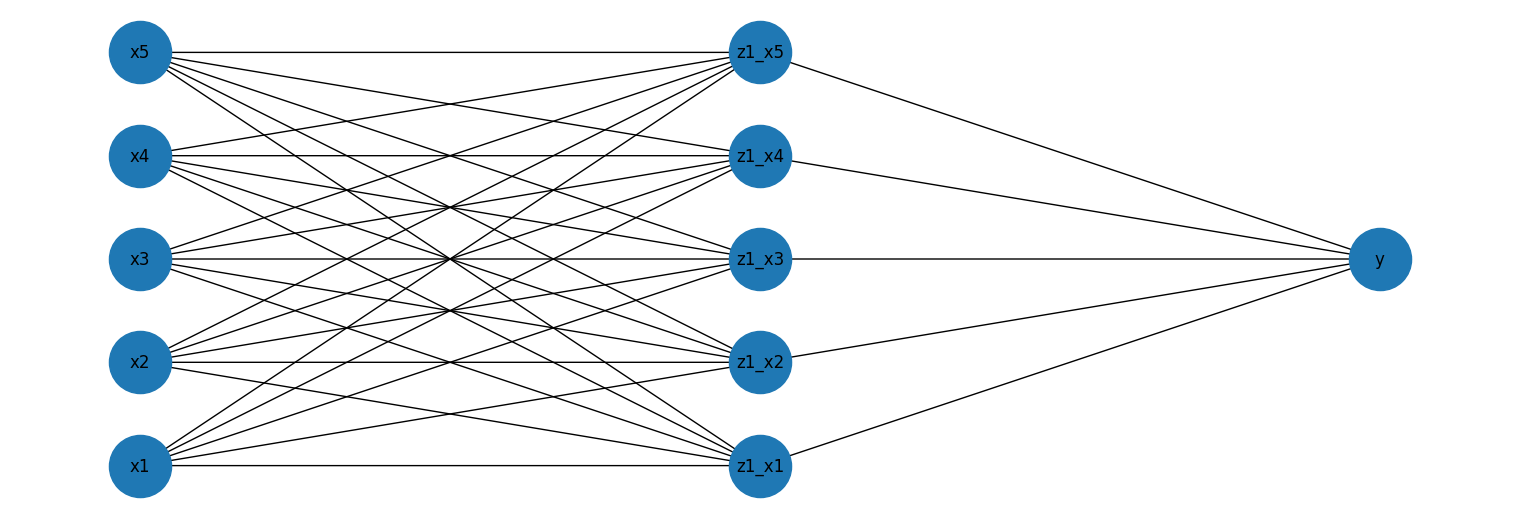

In [106]:
nn = NeuralNet()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#no border
_ = fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
_ = ax.axis('off')
_ = nn.plot_network_graph(ax)

y_true       27.30000000000000071054
y_pred       38.02716355178918661295
train_loss   97.12061785265366609110
test_loss    77.15294217132745302479
dtype: float64

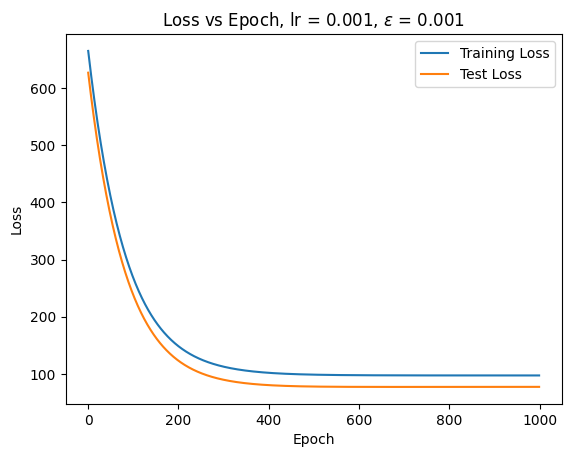

In [171]:
nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0],
        nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
nn.plot_loss()

array([[0.72072855],
       [0.83149522],
       [0.96558723],
       [0.79850015],
       [0.27740524]])

In [90]:
nn.predict(fake_values)

array([[38.0238012]])

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/2096815783.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


y_true       27.30000000000000071054
y_pred       28.25593051725304505339
train_loss   51.25341812024355903077
test_loss    34.57915929575762703507
dtype: float64

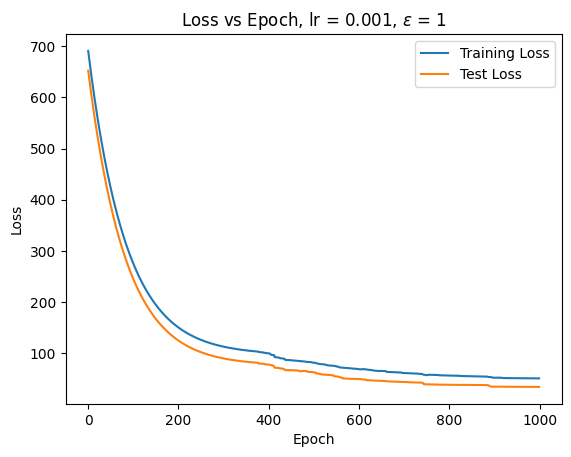

In [91]:
nn = NeuralNet()
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, eps=1)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0],
        nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
nn.plot_loss()

In [34]:
y_test.T[0]

array([27.3, 42. , 37.5, 49.8, 26.9, 18.6, 37.7, 33.1, 42.5, 31.3, 38.1,
       62.1, 36.7, 23.6, 19.2, 12.8, 15.6, 39.6, 38.4, 22.8, 36.5, 35.6,
       30.9, 36.3, 50.4, 42.9, 37. , 53.5, 46.6, 41.2, 37.9, 30.8, 11.2,
       53.7, 47. , 42.3, 28.6, 25.7, 31.3, 30.1, 60.7, 45.3, 44.9, 45.1,
       24.7, 47.1, 63.3, 40. , 48. , 33.1, 29.5, 24.8, 20.9, 43.1, 22.8,
       42.1, 51.7, 41.5, 52.2, 49.5, 23.8, 30.5, 56.8, 37.4, 69.7, 53.3,
       47.3, 29.3, 40.3, 12.9, 46.6, 55.3, 25.6, 27.3, 67.7, 38.6, 31.3,
       35.3, 40.3, 24.7, 42.5, 31.9, 32.2, 23. , 37.3, 35.5, 27.7, 28.5,
       39.7, 41.2, 37.2, 40.5, 22.3, 28.1, 15.4, 50. , 40.6, 52.5, 63.9])

In [35]:
nn.predict(X_test).T[0]

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/3997015667.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


array([28.2193612 , 42.82547121, 42.82547121, 42.82547121, 42.82547121,
       20.582511  , 42.82547121, 42.82547121, 42.82547121, 28.2193612 ,
       42.82547121, 42.82547121, 42.82547121, 28.2193612 , 20.582511  ,
       28.2193612 , 20.582511  , 42.82547121, 42.82547121, 35.1932769 ,
       42.82547121, 28.2193612 , 42.82547121, 42.82547121, 42.82547121,
       42.82547121, 42.82547121, 42.82547121, 42.82547121, 20.582511  ,
       42.82547121, 28.2193612 , 20.582511  , 42.82547121, 42.82547121,
       42.82547121, 28.2193612 , 28.2193612 , 28.2193612 , 28.2193612 ,
       42.82547121, 42.82547121, 42.82547121, 42.82547121, 28.2193612 ,
       42.82547121, 42.82547121, 42.82547121, 42.82547121, 42.82547121,
       28.2193612 , 28.2193612 , 28.2193612 , 42.82547121, 28.2193612 ,
       42.82547121, 42.82547121, 42.82547121, 42.82547121, 42.82547121,
       28.2193612 , 28.2193612 , 42.82547121, 42.82547121, 42.82547121,
       42.82547121, 42.82547121, 20.582511  , 42.82547121, 20.58

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/2190381686.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


y_true        27.30000000000000071054
y_pred        54.57165171059673980380
train_loss   232.08564094685402778850
test_loss    221.02650238361138690379
dtype: float64

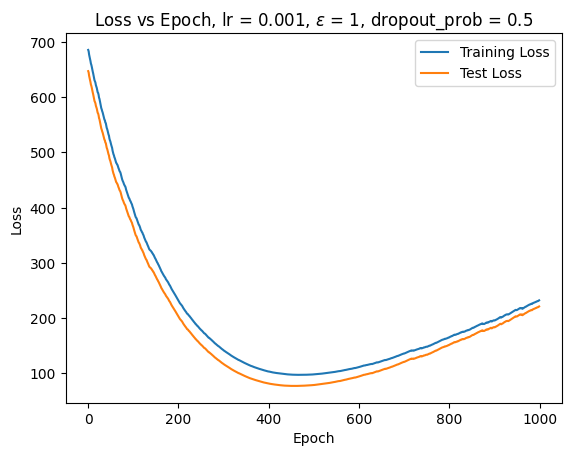

In [96]:
nn_dropout = NeuralNet()
nn_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001, eps=1, dropout=True, dropout_prob=0.5)
display(pd.Series(
    [
        y_test[0][0], 
        nn_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_dropout.get_training_loss()[-1][0],
        nn_dropout.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
nn_dropout.plot_loss()

In [192]:
nn_dropout.predict(fake_values)

array([[54.67663742]])

In [97]:
nn_dropout = NeuralNet()
nn_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=10000, lr=0.001, eps=1, dropout=True, dropout_prob=0.8)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/2190381686.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[]

In [98]:
display(pd.Series(
    [
        y_test[0][0], 
        nn_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_dropout.get_training_loss()[-1][0],
        nn_dropout.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/2190381686.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


y_true       27.30000000000000071054
y_pred       27.03129468321976958123
train_loss   81.88821280122679979740
test_loss    67.04257310569889227736
dtype: float64

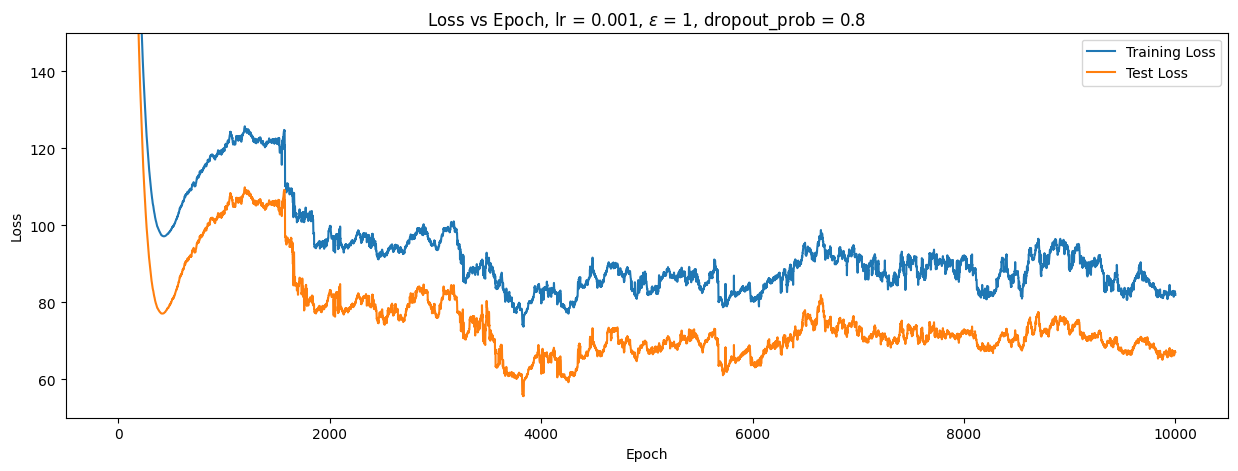

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_ylim(50, 150)
nn_dropout.plot_loss(ax=ax)

In [36]:
y_test.T[0]

array([27.3, 42. , 37.5, 49.8, 26.9, 18.6, 37.7, 33.1, 42.5, 31.3, 38.1,
       62.1, 36.7, 23.6, 19.2, 12.8, 15.6, 39.6, 38.4, 22.8, 36.5, 35.6,
       30.9, 36.3, 50.4, 42.9, 37. , 53.5, 46.6, 41.2, 37.9, 30.8, 11.2,
       53.7, 47. , 42.3, 28.6, 25.7, 31.3, 30.1, 60.7, 45.3, 44.9, 45.1,
       24.7, 47.1, 63.3, 40. , 48. , 33.1, 29.5, 24.8, 20.9, 43.1, 22.8,
       42.1, 51.7, 41.5, 52.2, 49.5, 23.8, 30.5, 56.8, 37.4, 69.7, 53.3,
       47.3, 29.3, 40.3, 12.9, 46.6, 55.3, 25.6, 27.3, 67.7, 38.6, 31.3,
       35.3, 40.3, 24.7, 42.5, 31.9, 32.2, 23. , 37.3, 35.5, 27.7, 28.5,
       39.7, 41.2, 37.2, 40.5, 22.3, 28.1, 15.4, 50. , 40.6, 52.5, 63.9])

In [37]:
nn_dropout.predict(X_test).T[0]

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/3997015667.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


array([27.60625965, 55.27042635, 55.27042635, 55.27042635, 55.27042635,
       27.60625965, 36.26839386, 55.27042635, 55.27042635, 27.60625965,
       55.27042635, 55.27042635, 45.65124859, 27.60625965, 27.60625965,
       27.60625965, 27.60625965, 55.27042635, 55.27042635, 36.26839386,
       55.27042635, 27.60625965, 55.27042635, 55.27042635, 55.27042635,
       55.27042635, 55.27042635, 55.27042635, 55.27042635, 27.60625965,
       55.27042635, 27.60625965, 27.60625965, 55.27042635, 55.27042635,
       55.27042635, 27.60625965, 27.60625965, 27.60625965, 27.60625965,
       55.27042635, 55.27042635, 55.27042635, 55.27042635, 27.60625965,
       55.27042635, 55.27042635, 36.26839386, 55.27042635, 55.27042635,
       27.60625965, 27.60625965, 27.60625965, 55.27042635, 27.60625965,
       55.27042635, 55.27042635, 55.27042635, 55.27042635, 55.27042635,
       27.60625965, 27.60625965, 55.27042635, 55.27042635, 55.27042635,
       55.27042635, 55.27042635, 27.60625965, 55.27042635, 27.60

y_true       27.30000000000000071054
y_pred       37.27906180354663945309
train_loss   97.46595392648119116075
test_loss    77.09223407010044581966
dtype: float64

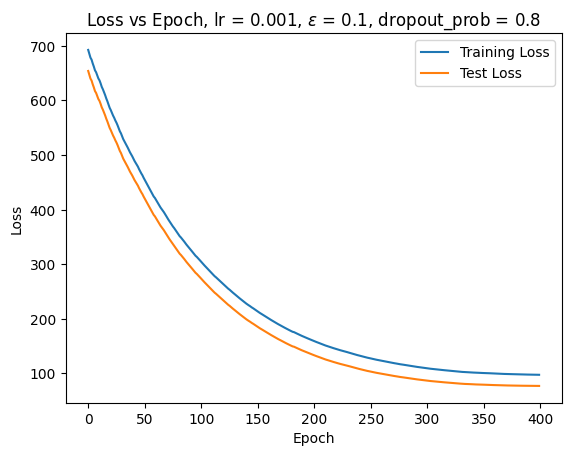

In [100]:
nn_400_dropout = NeuralNet()
nn_400_dropout.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=400, lr=0.001, eps=0.1, dropout=True, dropout_prob=0.8)
display(pd.Series(
    [
        y_test[0][0], 
        nn_400_dropout.predict(X_test[0].reshape(1, -1))[0][0],
        nn_400_dropout.get_training_loss()[-1][0],
        nn_400_dropout.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))
nn_400_dropout.plot_loss()

In [45]:
nn_400_dropout.predict(fake_values)

array([[37.46453917]])

In [46]:
y_test.T[0]

array([27.3, 42. , 37.5, 49.8, 26.9, 18.6, 37.7, 33.1, 42.5, 31.3, 38.1,
       62.1, 36.7, 23.6, 19.2, 12.8, 15.6, 39.6, 38.4, 22.8, 36.5, 35.6,
       30.9, 36.3, 50.4, 42.9, 37. , 53.5, 46.6, 41.2, 37.9, 30.8, 11.2,
       53.7, 47. , 42.3, 28.6, 25.7, 31.3, 30.1, 60.7, 45.3, 44.9, 45.1,
       24.7, 47.1, 63.3, 40. , 48. , 33.1, 29.5, 24.8, 20.9, 43.1, 22.8,
       42.1, 51.7, 41.5, 52.2, 49.5, 23.8, 30.5, 56.8, 37.4, 69.7, 53.3,
       47.3, 29.3, 40.3, 12.9, 46.6, 55.3, 25.6, 27.3, 67.7, 38.6, 31.3,
       35.3, 40.3, 24.7, 42.5, 31.9, 32.2, 23. , 37.3, 35.5, 27.7, 28.5,
       39.7, 41.2, 37.2, 40.5, 22.3, 28.1, 15.4, 50. , 40.6, 52.5, 63.9])

In [54]:
nn_400_dropout.predict(X_test).T[0]

array([37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46453917,
       37.46453917, 37.46453917, 37.46453917, 37.46453917, 37.46

In [101]:
hyper_nn = NeuralNet()
hyper_nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=50000, lr=0.001, eps=1, dropout=True, dropout_prob=0.8)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/2190381686.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[]

In [102]:
display(pd.Series(
    [
        y_test[0][0], 
        hyper_nn.predict(X_test[0].reshape(1, -1))[0][0],
        hyper_nn.get_training_loss()[-1][0],
        hyper_nn.get_test_loss()[-1][0],
    ], 
    index=["y_true", "y_pred", "train_loss", "test_loss"]
))

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/2190381686.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


y_true       27.30000000000000071054
y_pred       28.12064270715838176784
train_loss   96.12452944561505319143
test_loss    79.64967781583217742991
dtype: float64

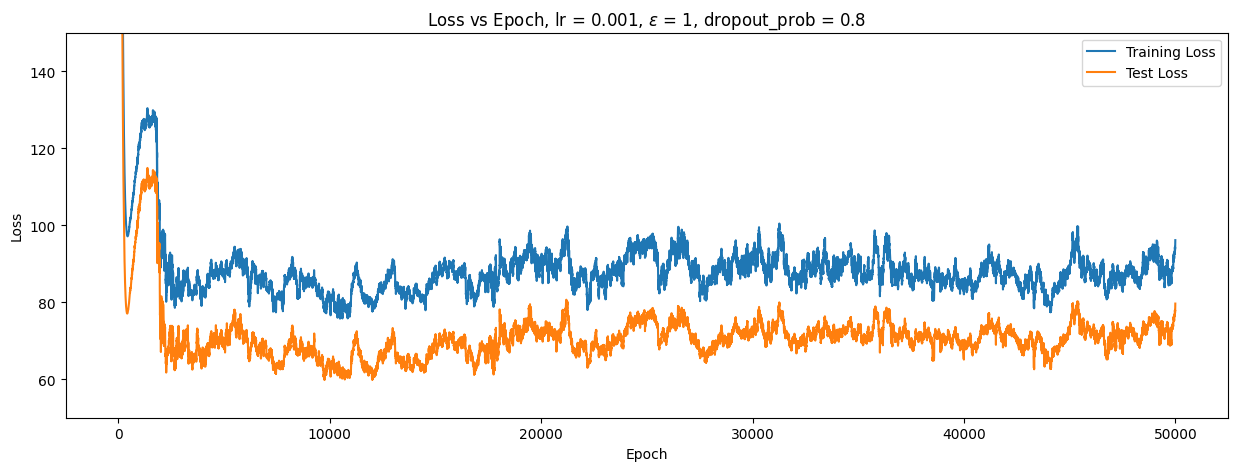

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_ylim(50, 150)
hyper_nn.plot_loss(ax=ax)

In [104]:
# Find lowest training loss and its epoch number

m = min(hyper_nn.get_training_loss(), key=lambda x: x[0])
e = hyper_nn.get_training_loss().index(m)

print(f"Lowest training loss: {m[0]:.2f} at epoch {e}")

Lowest training loss: 75.74 at epoch 10480


In [82]:
hyper_nn_ = NeuralNet()
hyper_nn_.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=e, lr=0.001, eps=1, dropout=True, dropout_prob=0.8)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/3997015667.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[]

In [83]:
hyper_nn_.predict(X_test).T[0]

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_1661/3997015667.py:28: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


array([32.55701059, 53.23909357, 53.23909357, 53.23909357, 53.23909357,
       32.55701059, 32.55701059, 53.23909357, 53.23909357, 32.55701059,
       53.23909357, 53.23909357, 53.23909357, 32.55701059, 32.55701059,
       32.55701059, 32.55701059, 53.23909357, 53.23909357, 32.55701059,
       53.23909357, 32.55701059, 53.23909357, 53.23909357, 53.23909357,
       53.23909357, 53.23909357, 53.23909357, 53.23909357, 32.55701059,
       53.23909357, 32.55701059, 32.55701059, 53.23909357, 53.23909357,
       53.23909357, 32.55701059, 32.55701059, 32.55701059, 32.55701059,
       53.23909357, 53.23909357, 53.23909357, 53.23909357, 32.55701059,
       53.23909357, 53.23909357, 32.55701059, 53.23909357, 53.23909357,
       32.55701059, 32.55701059, 32.55701059, 53.23909357, 32.55701059,
       53.23909357, 53.23909357, 53.23909357, 53.23909357, 53.23909357,
       32.55701059, 32.55701059, 53.23909357, 53.23909357, 53.23909357,
       53.23909357, 53.23909357, 32.55701059, 53.23909357, 32.55

y_true        27.30000000000000071054
y_pred        57.63734020134181434969
train_loss   287.87181630280230137942
dtype: float64

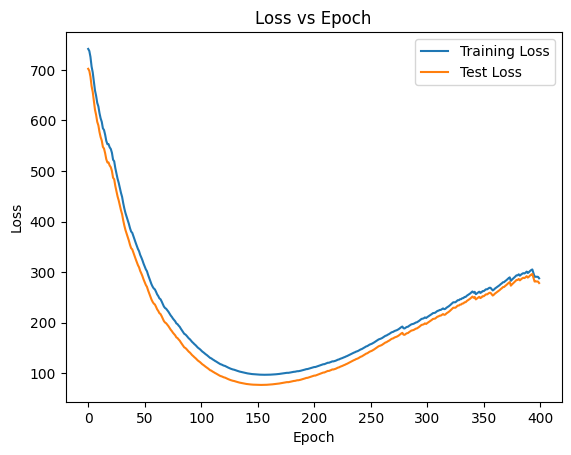

In [130]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.003, epochs=400, dropout=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))
nn.plot_loss()

y_true        27.30000000000000071054
y_pred        46.12380957676615622631
train_loss   107.23579872377744948153
dtype: float64

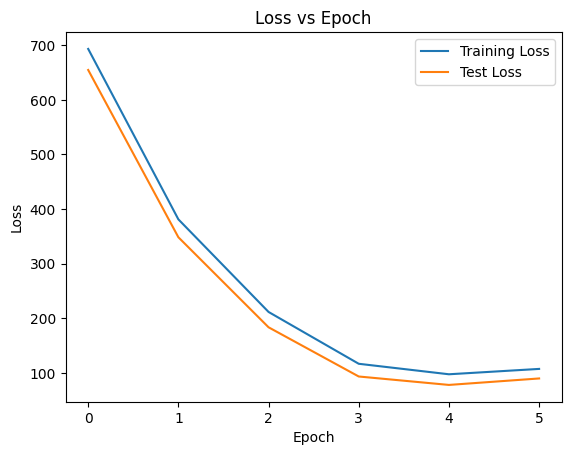

In [17]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.1, epochs=6, dropout=True)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))
nn.plot_loss()

y_true       27.30000000000000071054
y_pred       38.08070395479550995788
train_loss   97.11804055562443238614
dtype: float64

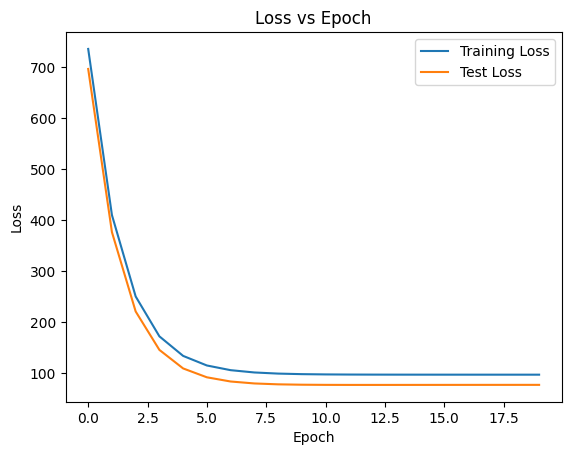

In [18]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=0.05, epochs=20)
display(pd.Series(
    [
        y_test[0][0], 
        nn.predict(X_test[0].reshape(1, -1))[0][0],
        nn.get_training_loss()[-1][0]
    ], 
    index=["y_true", "y_pred", "train_loss"]
))
nn.plot_loss()

In [151]:
# Brute force para encontrar el mejor número de epochs y learning rate

lrs = np.linspace(0.001, 0.5, 10).round(3)
eps = list(range(1, 1000, 50))

train_losses = {}
test_losses = {}

for lr, ep in tqdm(list(itertools.product(lrs, eps))):
    nn = NeuralNet()
    nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, lr=lr, epochs=int(ep))
    
    train_losses[(lr, int(ep))] = nn.get_training_loss()[-1][0]
    test_losses[(lr, int(ep))] = nn.get_test_loss()[-1][0]

100%|██████████| 200/200 [06:15<00:00,  1.88s/it]


In [154]:
train_losses_arr = []
test_losses_arr = []

for (lr, ep), loss in train_losses.items():
    train_losses_arr.append((lr, int(ep), loss))

for (lr, ep), loss in test_losses.items():
    test_losses_arr.append((lr, int(ep), loss))

train_losses_df = pd.DataFrame(train_losses_arr, columns=['lr', 'epochs', 'loss'])
test_losses_df = pd.DataFrame(test_losses_arr, columns=['lr', 'epochs', 'loss'])

# merge dataframes
losses_df = pd.merge(train_losses_df, test_losses_df, on=['lr', 'epochs'], suffixes=('_train', '_test'))
losses_df

,lr,epochs,loss_train,loss_test
0,0.00100000000000000002,1,712.35544408202019894816,673.50730859418263207772
1,0.00100000000000000002,51,438.10390531169031191894,404.09167713681171107964
2,0.00100000000000000002,101,277.70827155145241249556,247.53186235583663687976
3,0.00100000000000000002,151,204.45153606491405184897,176.62372830443592874872
4,0.00100000000000000002,201,152.95659639606813584578,127.33201401750525860734
...,...,...,...,...
195,0.50000000000000000000,751,"10,064,873,608,080,629,039,315,616,564,842,070,...","10,064,873,608,080,626,678,132,375,130,019,463,..."
196,0.50000000000000000000,801,"38,883,928,850,905,498,030,357,258,510,008,320....","38,883,928,850,905,493,418,671,240,082,620,416...."
197,0.50000000000000000000,851,"1,964,394,829,934,937,164,113,258,741,760.00000...","1,964,394,829,934,938,571,488,142,295,040.00000..."
198,0.50000000000000000000,901,"161,643,292,004,524,220,750,446,944,777,003,859...","161,643,292,004,524,220,750,446,944,777,003,859..."


In [160]:
losses_df.sort_values(by='loss_test', ascending=True).head(10)

,lr,epochs,loss_train,loss_test
14,0.00100000000000000002,701,97.24997849157063001257,77.04882381592535978143
13,0.00100000000000000002,651,97.36517063828993912011,77.06209465460953822458
15,0.00100000000000000002,751,97.18700042019692375561,77.06229356767643423609
16,0.00100000000000000002,801,97.15765470153172600476,77.08106987569057366727
17,0.00100000000000000002,851,97.13886442836047763194,77.10344679716750704301
12,0.00100000000000000002,601,97.53729094639008678769,77.11963007880184761689
18,0.00100000000000000002,901,97.12979841319094020946,77.12105310560889392946
19,0.00100000000000000002,951,97.12443781084131444459,77.13643326268517341759
148,0.38900000000000001243,401,97.11721857464502249968,77.19205646245166008157
182,0.50000000000000000000,101,97.11721191618177329019,77.19363039787369018541


In [161]:
losses_df.sort_values(by='loss_train', ascending=True).head(10)

,lr,epochs,loss_train,loss_test
81,0.22300000000000000377,51,97.11721158982109614044,77.19406594744638994143
98,0.22300000000000000377,901,97.11721158982109614044,77.19406594746409666641
118,0.27800000000000002487,901,97.11721158982109614044,77.19406594745940708435
26,0.05600000000000000117,301,97.11721158982109614044,77.19406594745862548734
95,0.22300000000000000377,751,97.11721158982109614044,77.19406594745851180051
45,0.11200000000000000233,251,97.11721158982109614044,77.19406594745805705315
42,0.11200000000000000233,101,97.11721158982109614044,77.19406594745773020350
44,0.11200000000000000233,201,97.11721158982109614044,77.19406594745751704068
28,0.05600000000000000117,401,97.11721158982109614044,77.19406594745743177555
71,0.16700000000000000955,551,97.11721158982109614044,77.19406594745981919914


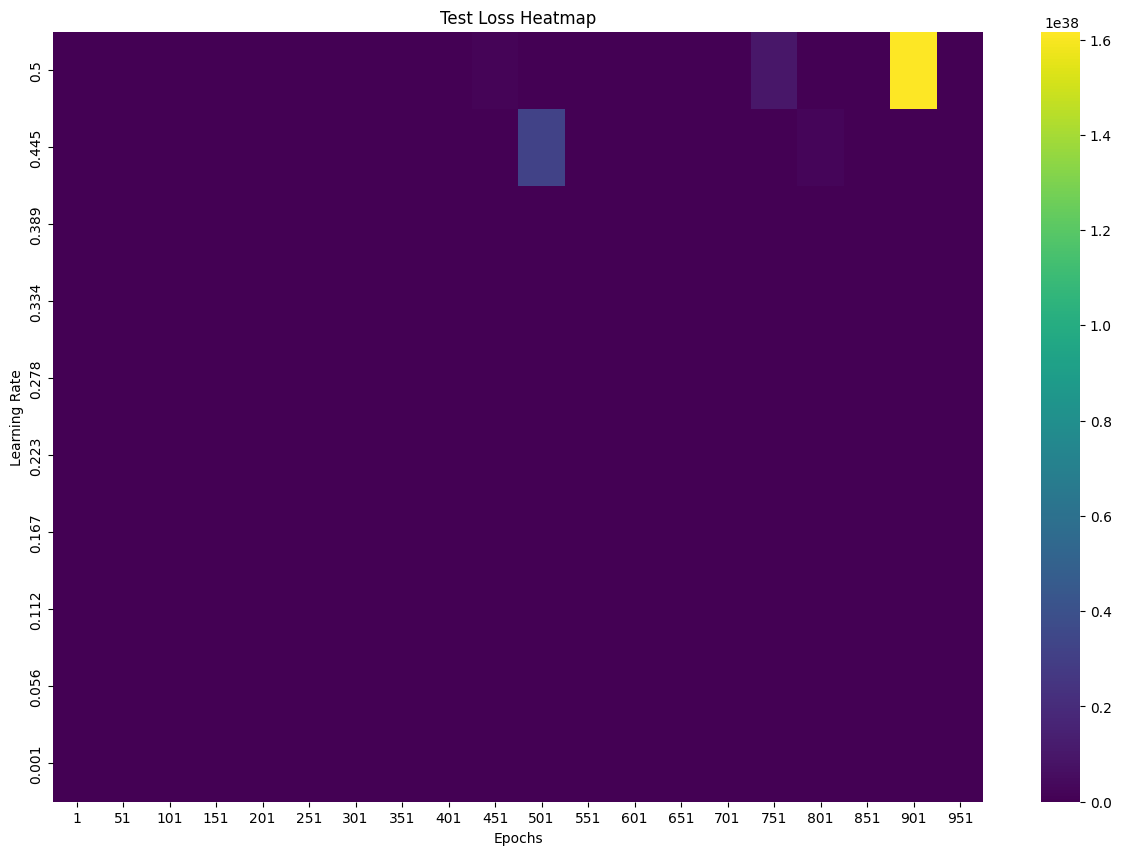

In [163]:
losses_df_hm = losses_df.pivot(index='lr', columns='epochs', values='loss_test')

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(losses_df_hm, ax=ax, cmap='viridis')
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_title('Test Loss Heatmap')
ax.invert_yaxis()
plt.show()

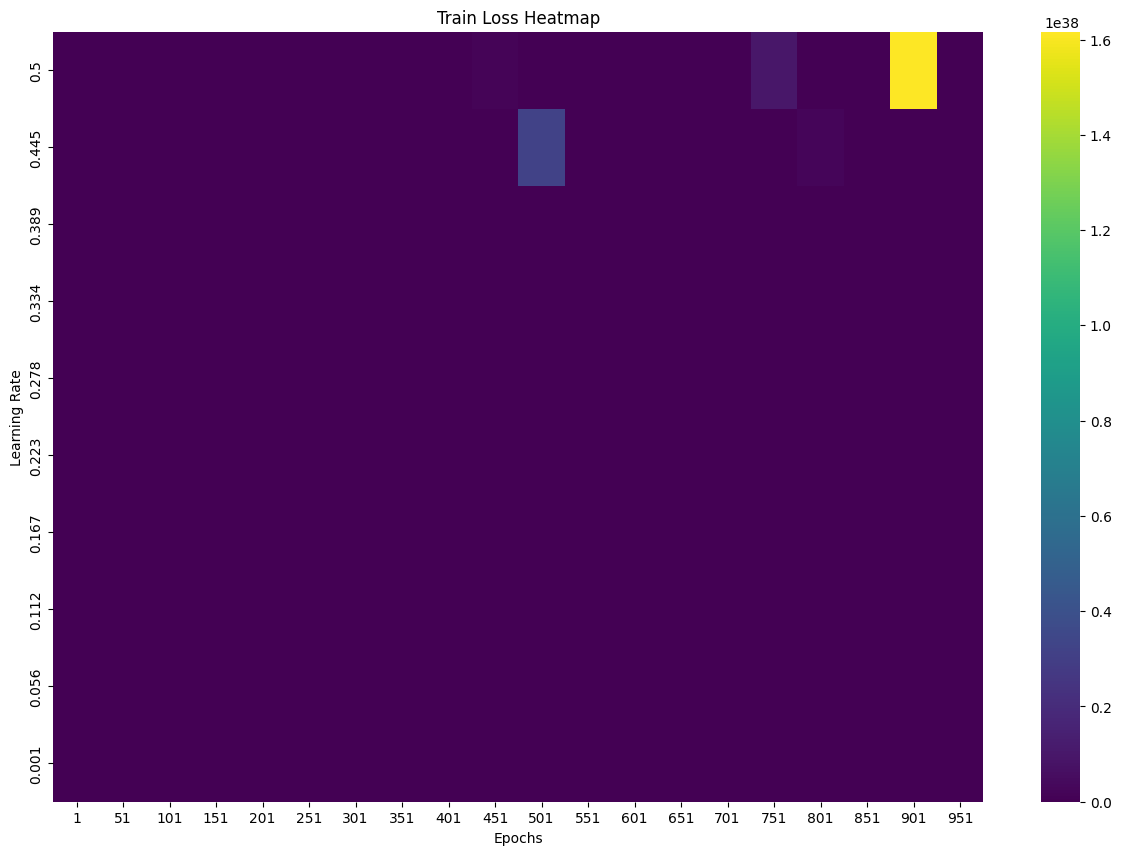

In [164]:
losses_df_hm = losses_df.pivot(index='lr', columns='epochs', values='loss_train')

fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(losses_df_hm, ax=ax, cmap='viridis')
ax.set_xlabel('Epochs')
ax.set_ylabel('Learning Rate')
ax.set_title('Train Loss Heatmap')
ax.invert_yaxis()
plt.show()

In [159]:
nn = NeuralNet()
w1, b1, w2, b2 = nn.get_weights()

In [160]:
pd.DataFrame(w1)

,0,1,2,3,4,5
0,0.53548707766361425264,0.75246769630198584444,0.02514831280222507015,0.81340208281879144980,0.97951899993289925916,0.11762248820539300542
1,0.67441409182298028835,0.33562131491435187591,0.80027686558991006915,0.43632392269717457101,0.08230147206270421734,0.29243005566312441079
2,0.94825845845404943546,0.30622453477202782324,0.37708759956373594235,0.37061069305249194628,0.30157970454769278401,0.51192765459541644812
3,0.82395104433472088346,0.28445056067180007897,0.59692455165714586318,0.19857146945641934721,0.19136085504156741255,0.33187947109895543640
4,0.15159179656532584257,0.17262333695370546405,0.11625749672969531989,0.23286344715904383484,0.70103323392395000546,0.49616888705681228000


In [161]:
pd.DataFrame(b1)

,0
0,0.03926124788404161681
1,0.28434036302986609446
2,0.10754486064718282723
3,0.54135927958311569341
4,0.88010245491494476511


In [162]:
pd.DataFrame(w2)

,0,1,2,3,4
0,0.12932754711565785932,0.73713867505328378726,0.19114363043256843433,0.68103991330771929125,0.97096318967470074401


In [163]:
pd.DataFrame(b2)

,0
0,0.54999773574876220650


In [164]:
nn.fit(X_train, y_train, x_test=X_test, y_test=y_test, epochs=1000, lr=0.001)

[]

In [130]:
w1_, b1_, w2_, b2_ = nn.get_weights()

In [167]:
pd.DataFrame(w1_)

,0,1,2,3,4,5
0,0.90621132258362324663,0.99689499656433100405,0.98479141957820737208,0.25780684592847735725,0.78974995261350910969,0.72161417115460946281
1,0.86777185882013674334,0.84764708756116979860,0.85887612814214164825,0.83596693759156859294,0.14727167910983185450,0.73856649879452984653
2,0.51212210056711093831,0.91262721921244183143,0.94892018573842695783,0.57322810011255231899,0.81704054792653058037,0.33361092183666030131
3,0.02104509806699084162,0.83354813616095380091,0.02597560815013488789,0.33273024692678987435,0.54986848476863947610,0.28034895502099654863
4,0.23981254146919572801,0.24536248340819566405,0.41007744929505940412,0.63084291529635438955,0.33159925141684565286,0.93097302624933986337
